# Combining tides with satellite data

[![Download Jupyter Notebook](https://img.shields.io/badge/Jupyter%20Notebook-Download%20on%20GitHub-F37626?logo=jupyter&logoColor=white)](https://github.com/GeoscienceAustralia/eo-tides/blob/main/docs/notebooks/Satellite_data.ipynb)
[![Python API Reference](https://img.shields.io/badge/Python-API%20Reference-3776AB?logo=python&logoColor=white)](../../api/#eo_tides.eo)

**This guide demonstrates how to combine tide modelling with satellite Earth observation (EO) data using the [`tag_tides`](../../api/#eo_tides.eo.tag_tides) and [`pixel_tides`](../../api/#eo_tides.eo.pixel_tides) functions from [`eo_tides.eo`](../../api/#eo_tides.eo).**

---

Both these functions allow you to model the height of the tide at the exact moment of satellite image acquisition. 
This can then allow you to analyse satellite EO data by tidal conditions - for example, filter your data to satellite imagery collected during specific tidal stages (e.g. low or high tide).

Although both functions perform a similar function, they differ in complexity and performance. `tag_tides` assigns a single tide height to each timestep/satellite image, which is fast and efficient, and suitable for small-scale applications where tides are unlikely to vary across your study area. In constrast, `pixel_tide` models tides both through time *and* spatially, returning a tide height for every satellite pixel. This can be critical for producing seamless coastal EO datasets at large scale - however comes at the cost of performance.
<br><br>
> **Table 1.** Comparison of `tag_tides` and `pixel_tides`

| [`tag_tides`](../../api/#eo_tides.eo.tag_tides)                                                                 | [`pixel_tides`](../../api/#eo_tides.eo.pixel_tides)                                                                                              |
|-----------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
| Assigns a single tide height to each timestep/satellite image                         | Assigns a tide height to every individual pixel through time to capture spatial tide dynamics                                               |
| 🔎 Ideal for local or site-scale analysis                                      | 🌏 Ideal for regional to global-scale coastal product generation                                              |
| ✅ Fast, low memory use                                                        | ❌ Slower, higher memory use                                                                                  |
| ❌ Single tide height per image can produce artefacts in complex tidal regions | ✅ Produce spatially seamless results across large extents by applying analyses at the pixel level |

## Getting started
As in the previous example, our first step is to tell `eo-tides` the location of our tide model directory (if you haven't set this up, [refer to the setup instructions here](../../setup)).

We can also define the tide model we want to use the for analysis; for example, the default model "EOT20".

In [1]:
directory = "../../tests/data/tide_models/"
model = "EOT20"

## Load satellite data using odc-stac

Now we can load a time-series of satellite data over our area of interest using the Open Data Cube's `odc-stac` package.
This powerful package allows us to load open satellite data (e.g ESA Sentinel-2 or NASA/USGS Landsat) for any time period and location on the planet, and load our data into a multi-dimensional `xarray.Dataset` format dataset.


In this example, we will load **Sentinel-2 satellite data from 2024 over the city of Broome, Western Australia** - a macrotidal region with extensive intertidal coastal habitats.
We will load this data from the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) STAC catalogue.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed guide to using STAC metadata and <code>odc-stac</code> to find and load satellite data, refer to the <a href="https://odc-stac.readthedocs.io/en/latest/intro.html">odc-stac Python package documentation</a>. <code>eo-tides</code> is compatible with satellite data loaded from any STAC API, for example <a href="https://knowledge.dea.ga.gov.au/guides/setup/gis/stac/">Digital Earth Australia</a>.
    </p>
</div>

/workspaces/eo-tides/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


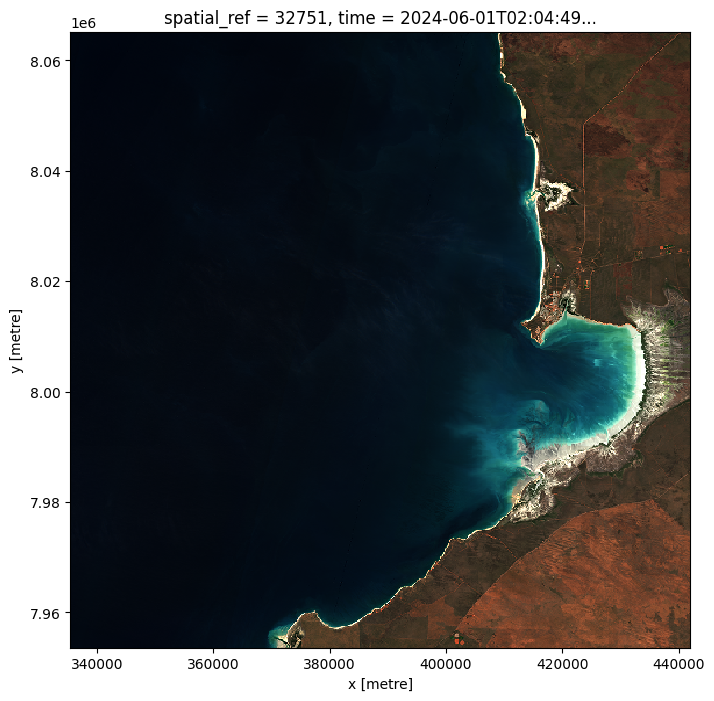

In [2]:
import odc.stac
import pystac_client
import planetary_computer

# Connect to STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [121.45, -18.50, 122.45, -17.50]
query = catalog.search(
    bbox=bbox,
    collections=["sentinel-2-l2a"],
    datetime="2024-06-01/2024-09-01",
    query={"eo:cloud_cover": {"lt": 5}},  # Filter to images with <5% cloud
)

# Load data into xarray format
ds = odc.stac.load(
    items=list(query.items()),
    bands=["red", "green", "blue"],
    crs="utm",
    resolution=200,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

# Rescale data to be between 0 and 1 using ESA offset/scaling factors
ds = (ds - 1000) / 10000

# Plot a sample image
ds.isel(time=0).odc.to_rgba(vmin=0.0, vmax=0.3).plot.imshow(aspect=1, size=8)

## Using tag_tides

We can pass our satellite dataset `ds` to the `tag_tides` function to model a tide for each timestep in our dataset.
This can help sort and filter images by tide height, allowing us to learn more about how coastal environments respond to the effect of changing tides.

The `tag_tides` function uses the time and date of acquisition and the geographic centroid of each satellite observation as inputs for the selected tide model (EOT20 by default). 
It returns an `xarray.DataArray` called `tide_height`, with a modelled tide for every timestep in our satellite dataset:

In [3]:
from eo_tides.eo import tag_tides

tides_da = tag_tides(
    data=ds,
    model=model,
    directory=directory,
)

# Print modelled tides
print(tides_da)

Setting tide modelling location from dataset centroid: 121.95, -18.00
Modelling tides with EOT20
<xarray.DataArray 'tide_height' (time: 18)> Size: 72B
array([-0.9348628 ,  3.3274708 ,  0.20504647, -0.551178  ,  2.598168  ,
        0.17249022, -1.1744568 ,  2.7656622 , -0.4711703 , -0.88106734,
        2.633608  , -1.0514739 , -0.64030755, -0.76038957, -0.68517935,
        3.0605938 , -1.6012288 ,  0.43852195], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 144B 2024-06-01T02:04:49.024000 ... 202...
    tide_model  <U5 20B 'EOT20'


We can easily combine these modelled tides with our original satellite data for further analysis.
The code below adds our modelled tides as a new `tide_height` variable under **Data variables**.

In [4]:
ds["tide_height"] = tides_da
print(ds)

<xarray.Dataset> Size: 64MB
Dimensions:      (y: 558, x: 533, time: 18)
Coordinates:
  * y            (y) float64 4kB 8.065e+06 8.065e+06 ... 7.954e+06 7.954e+06
  * x            (x) float64 4kB 3.355e+05 3.357e+05 ... 4.417e+05 4.419e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 144B 2024-06-01T02:04:49.024000 ... 20...
    tide_model   <U5 20B 'EOT20'
Data variables:
    red          (time, y, x) float32 21MB dask.array<chunksize=(1, 558, 533), meta=np.ndarray>
    green        (time, y, x) float32 21MB dask.array<chunksize=(1, 558, 533), meta=np.ndarray>
    blue         (time, y, x) float32 21MB dask.array<chunksize=(1, 558, 533), meta=np.ndarray>
    tide_height  (time) float32 72B -0.9349 3.327 0.205 ... 3.061 -1.601 0.4385


<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        You could also model tides and insert them into <code>ds</code> in a single step via:<br>
        <code>ds["tide_height"] = tag_tides(ds, ...)</code>
    </p>
</div>

We can plot this new `tide_height` variable over time to inspect the tide heights observed by the satellites in our time series:

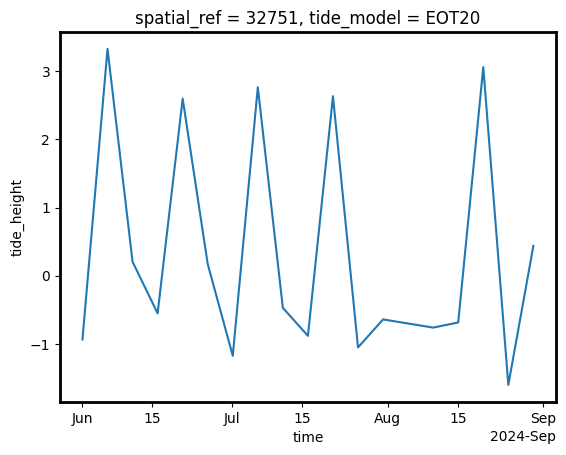

In [5]:
ds.tide_height.plot()

### Selecting and analysing satellite data by tide

Having `tide_height` as a variable allows us to select and analyse our satellite data using information about tides.
For example, we could sort by `tide_height`, then plot the lowest and highest tide images in our time series:

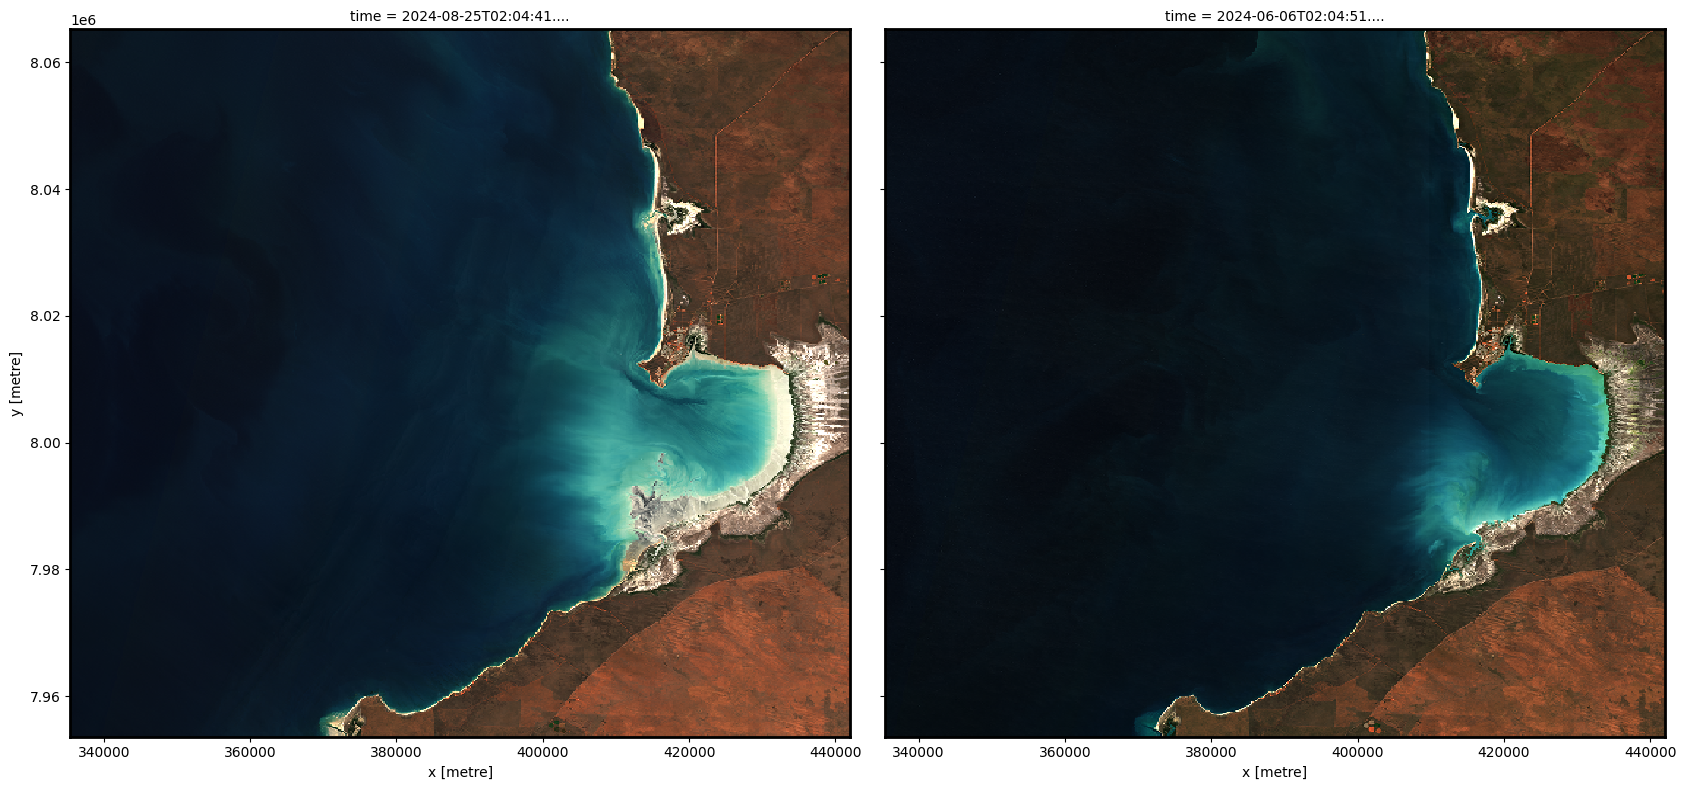

In [6]:
# Sort by tide and plot the first and last image
ds_sorted = ds.sortby("tide_height")
ds_sorted.isel(time=[0, -1]).odc.to_rgba(vmin=0, vmax=0.3).plot.imshow(col="time", size=8)

## Using pixel_tides

The previous examples show how to model a single tide height for each satellite image using the centroid of the image as a tide modelling location.
However, in reality tides vary spatially – potentially by several metres in areas of complex tidal dynamics.
This means that an individual satellite image can capture a range of tide conditions.

We can use the `pixel_tides` function to capture this spatial variability in tide heights. 
For efficient processing, this function first models tides into a low resolution grid surrounding each satellite image in our time series.
This lower resolution data includes a buffer around the extent of our satellite data so that tides can be modelled seamlessly across analysis boundaries.

`pixel_tides` can be run the same way as `tag_tides`, passing our satellite dataset `ds` as an input:

In [7]:
from eo_tides.eo import pixel_tides

# Model tides spatially
tides_lowres = pixel_tides(
    data=ds,
    resample=False,
    model=model,
    directory=directory,
)

# Inspect output
tides_lowres

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with EOT20
Returning low resolution tide array


<xarray.DataArray 'tide_height' (time: 18, y: 28, x: 27)> Size: 54kB
array([[[-0.72116035, -0.73185736, -0.7421772 , ..., -0.80055445,
         -0.647201  , -0.647201  ],
        [-0.72925097, -0.73974943, -0.7499135 , ..., -0.80055445,
         -0.80055445, -0.80055445],
        [-0.73734486, -0.7476439 , -0.75765216, ..., -0.8488726 ,
         -0.8488726 , -0.8488726 ],
        ...,
        [-0.947271  , -0.9538651 , -0.9600315 , ..., -0.9618166 ,
         -0.9618166 , -0.95252824],
        [-0.95641005, -0.9629303 , -0.9689272 , ..., -0.9618166 ,
         -0.9618166 , -0.9618166 ],
        [-0.96555036, -0.9719966 , -0.9778263 , ..., -0.9618166 ,
         -0.9618166 , -0.9618166 ]],

       [[ 2.605289  ,  2.6377003 ,  2.6695118 , ...,  2.9530902 ,
          2.845561  ,  2.845561  ],
        [ 2.6297379 ,  2.6616466 ,  2.6931841 , ...,  2.9530902 ,
          2.9530902 ,  2.9530902 ],
        [ 2.6541946 ,  2.6855965 ,  2.71686   , ...,  3.02641   ,
          3.02641   ,  3.02641   ],
...
        [-1.633211  , -1.6416978 , -1.6494474 , ..., -1.9040815 ,
         -1.9040815 , -1.9524901 ],
        [-1.6594347 , -1.6681415 , -1.676515  , ..., -1.9040815 ,
         -1.9040815 , -1.9040815 ],
        [-1.6856538 , -1.6945809 , -1.7035697 , ..., -1.9040815 ,
         -1.9040815 , -1.9040815 ]],

       [[ 0.30725136,  0.31271353,  0.31828293, ...,  0.45849606,
          0.5473158 ,  0.5473158 ],
        [ 0.31174752,  0.31712058,  0.32259056, ...,  0.45849606,
          0.45849606,  0.45849606],
        [ 0.31624508,  0.3215292 ,  0.3268997 , ...,  0.43953663,
          0.43953663,  0.43953663],
        ...,
        [ 0.42267856,  0.42760393,  0.43187803, ...,  0.5066416 ,
          0.5066416 ,  0.52104795],
        [ 0.42783332,  0.43287534,  0.43731016, ...,  0.5066416 ,
          0.5066416 ,  0.5066416 ],
        [ 0.43298575,  0.43814448,  0.44273934, ...,  0.5066416 ,
          0.5066416 ,  0.5066416 ]]], shape=(18, 28, 27), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 144B 2024-06-01T02:04:49.024000 ... 20...
  * x            (x) float64 216B 3.225e+05 3.275e+05 ... 4.475e+05 4.525e+05
  * y            (y) float64 224B 8.078e+06 8.072e+06 ... 7.948e+06 7.942e+06
    tide_model   <U5 20B 'EOT20'
    spatial_ref  int32 4B 32751

If we plot the resulting data, we can see that we now have two-dimensional tide surfaces for each timestep in our data (instead of the single tide height per timestamp returned by the `tag_tides` function).

<span style="color:red">Red</span> below indicates low tide pixels, while <span style="color:blue">blue</span> indicates high tide pixels. If you look closely, you may see some spatial variability in tide heights within each timestep, with slight variations in tide heights along the north-west side of the study area:

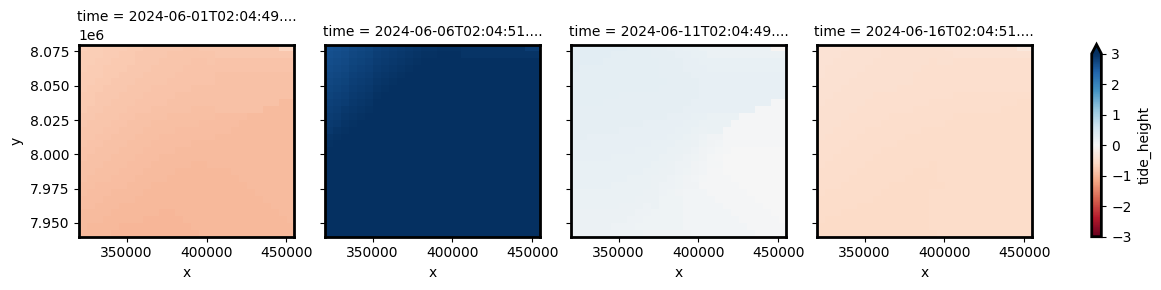

In [8]:
# Plot the first four timesteps in our data
tides_lowres.isel(time=[0, 1, 2, 3]).plot.imshow(col="time", vmin=-3, vmax=3, cmap="RdBu")

### Extrapolation

You may notice that modelled tides cover the entire 2D spatial extent of our images, even though the eastern side of our study area is land. 
This is because by default, `eo-tides` will extrapolate tide values into every pixel using nearest neighbour interpolation.
This ensures every coastal pixel is allocated a tide height, but can produce inaccurate results the further a pixel is located from the ocean. 

To turn off extrapolation, pass `extrapolate=False`:

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with EOT20
Returning low resolution tide array


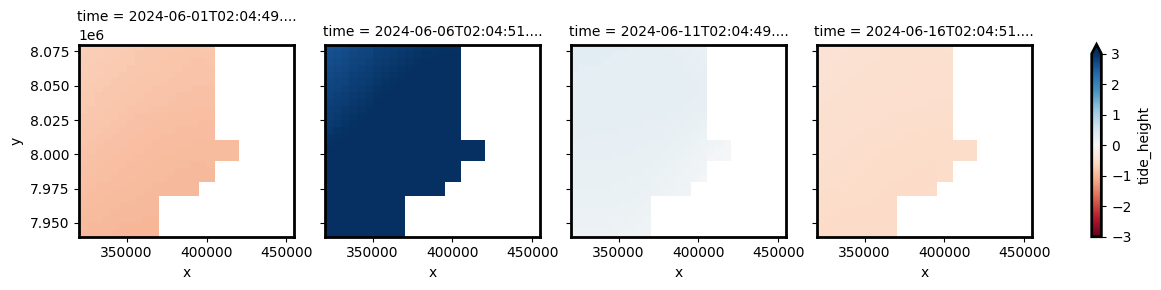

In [9]:
# Model tides spatially
tides_lowres = pixel_tides(
    data=ds,
    resample=False,
    extrapolate=False,
    model=model,
    directory=directory,
)

# Plot the first four timesteps in our data
tides_lowres.isel(time=[0, 1, 2, 3]).plot.imshow(col="time", vmin=-3, vmax=3, cmap="RdBu")


### Reprojecting into original high-resolution spatial grid

By setting `resample=True`, we can use interpolation to re-project our low resolution tide data back into the resolution of our satellite image, resulting in an individual **tide height for every pixel** in our dataset through time and space:

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with EOT20
Reprojecting tides into original resolution


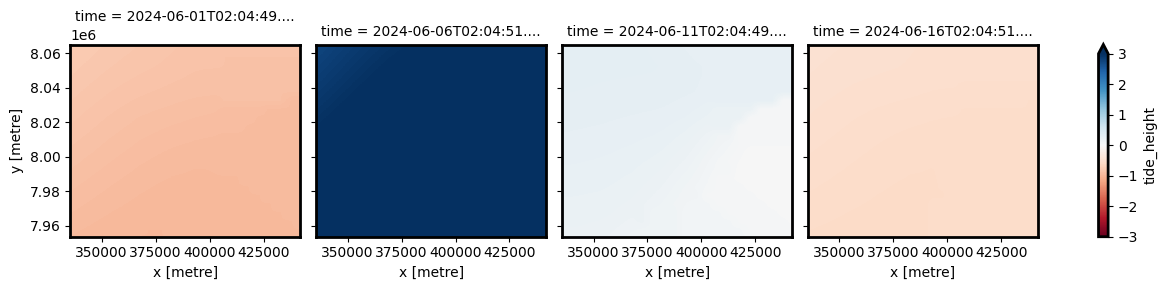

In [10]:
# Model tides spatially
tides_highres = pixel_tides(
    data=ds,
    resample=True,
    model=model,
    directory=directory,
)

# Plot the first four timesteps in our data
tides_highres.isel(time=[0, 1, 2, 3]).plot.imshow(col="time", vmin=-3, vmax=3, cmap="RdBu")

`tides_highres` will have exactly the same dimensions as `ds`, with a unique tide height for every satellite pixel:

In [11]:
print(f"x: {len(ds.x)}, y: {len(ds.y)}, time: {len(ds.time)}")

x: 533, y: 558, time: 18


In [12]:
print(f"x: {len(tides_highres.x)}, y: {len(tides_highres.y)}, time: {len(tides_highres.time)}")

x: 533, y: 558, time: 18


Because of this, our stack of tides can be added as an additional 3D variable in our dataset:

In [13]:
ds["tide_height"] = tides_highres
ds

<xarray.Dataset> Size: 86MB
Dimensions:      (y: 558, x: 533, time: 18)
Coordinates:
  * y            (y) float64 4kB 8.065e+06 8.065e+06 ... 7.954e+06 7.954e+06
  * x            (x) float64 4kB 3.355e+05 3.357e+05 ... 4.417e+05 4.419e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 144B 2024-06-01T02:04:49.024000 ... 20...
    tide_model   <U5 20B 'EOT20'
Data variables:
    red          (time, y, x) float32 21MB dask.array<chunksize=(1, 558, 533), meta=np.ndarray>
    green        (time, y, x) float32 21MB dask.array<chunksize=(1, 558, 533), meta=np.ndarray>
    blue         (time, y, x) float32 21MB dask.array<chunksize=(1, 558, 533), meta=np.ndarray>
    tide_height  (time, y, x) float32 21MB -0.7673 -0.7677 ... 0.5066 0.5066

### Calculating tide height min/max/median/quantiles for each pixel
Min, max or any specific quantile of all tide heights observed over a region can be calculated for each pixel by passing in a list of quantiles/percentiles using the `calculate_quantiles` parameter.

This calculation is performed on the low resolution modelled tide data before reprojecting to higher resolution, so should be faster than calculating min/max/median tide at high resolution:

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with EOT20
Computing tide quantiles
Reprojecting tides into original resolution


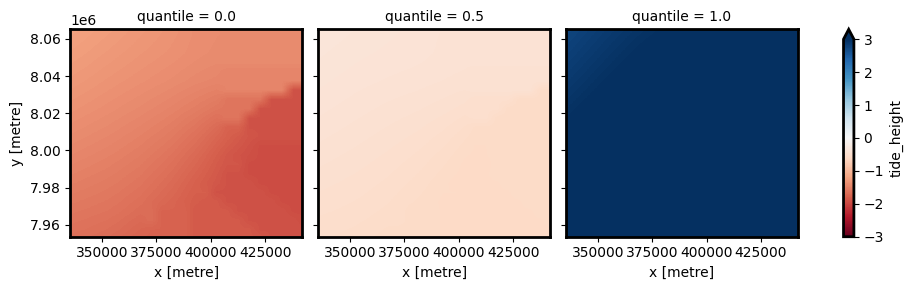

In [14]:
# Model tides spatially
tides_highres_quantiles = pixel_tides(
    data=ds,
    calculate_quantiles=(0, 0.5, 1),
    model=model,
    directory=directory,
)

# Plot tide height quantiles
tides_highres_quantiles.plot.imshow(col="quantile", vmin=-3, vmax=3, cmap="RdBu")

### Modelling custom times

Instead of using times contained in the `time` dimension of our dataset, we can also calculate pixel-based tides for a custom set of times:

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with EOT20
Reprojecting tides into original resolution


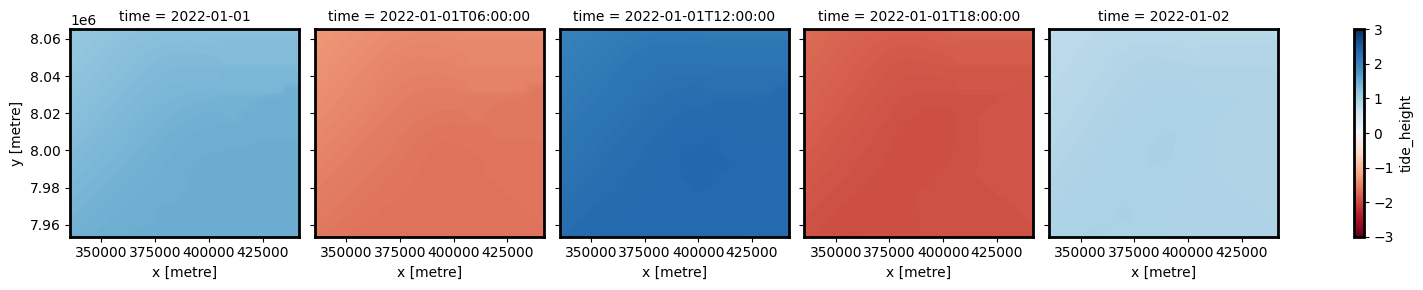

In [15]:
import pandas as pd

custom_times = pd.date_range(
    start="2022-01-01", 
    end="2022-01-02", 
    freq="6h",
)

# Model tides spatially
tides_highres = pixel_tides(
    data=ds, 
    time=custom_times,
    model=model,
    directory=directory,
)

# Plot custom timesteps
tides_highres.plot.imshow(col="time", vmin=-3, vmax=3, cmap="RdBu")

## Next steps

Now that we have learnt to combine tide modelling with satellite data, we can learn how to [calculate statistics](../Tide_statistics) describing local tide dynamics, as well as biases caused by interactions between tidal processes and satellite orbits.